
# Matthew Muller
1/19/23

Description:
- This script will train and evaluate a machine learning model using sklearn.

### Under the hood

In [1]:
########################################
# Library Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from scipy.stats import kruskal

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_curve, confusion_matrix

from joblib import load, dump

########################################
# Set/Append Working directory)

########################################
# Import Functions
from MattTools.plotting import plot_roc_curve, plot_confusion_matrix, plot_training_roc_curve_ci, plot_roc_curve_ci
from MattTools.plotting import plot_scree, plot_training_probas
from MattTools.stats import bootstrap_auc_confidence
from MattTools import utils

# Hide warnings
utils.hide_warnings()
utils.set_random_seed()

Setting random seed to 3040 for reproducibility.


### Load in Data

In [3]:
path = '../data/clean/'
# genes = pd.read_table('data/genes_pace__nyu_mi_v_control.txt', header=None).values
# genes = "ZNF444"

# Naming convention for below:
# X_train = pd.read_csv('hyper_norm_rank/output/simple_ranking/pace_simpleRank.csv', index_col=0).T
X_train = pd.read_csv(path+'pace/features.csv', index_col=0, header=0)

y_train = pd.read_csv(path+'pace/labels.csv').to_numpy()[:,0]


# X_test = pd.read_csv('hyper_norm_rank/output/simple_ranking/duke_simpleRank.csv', index_col=0, header=0).T
X_test = pd.read_csv(path+'duke/features_group1.csv')

y_test = pd.read_csv(path+'duke/labels_group1.csv').to_numpy()[:,0]

X_test2 = pd.read_csv(path+'duke/features_group2.csv')

y_test2 = pd.read_csv(path+'duke/labels_group2.csv').to_numpy()[:,0]

# X_train = X_train[genes]
# X_test = X_test[genes]

X_test.shape, X_train.shape

((35, 451), (84, 451))

### Run Model

In [4]:
#### Make model pipeline (if needed) and search for params
# The general idea here is fit each gene to a SVC and then add them into a voting classifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# good RF random seeds:
seeds = [1148093, 1095286, 1665788, 97057, 152878, 4543, 277452, 295106, 191278, 701043, 81388, 951209, 1327001, 527903, 1148093, 1095286, 1665788, 97057, 152878, 4543, 277452, 295106, 191278, 701043, 81388, 951209, 1327001, 527903]
n = 28
# seeds = [randint(0,1000000) for x in range(n)]
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    # ('pca', PCA()),
    # ('svc', SVC(probability=True, class_weight="balanced")),
    # ('knn', KNeighborsClassifier()),
    # ('logit', LogisticRegression(solver='saga', tol=1e3, max_iter=1000)),
    # ('percept', Perceptron(class_weight = 'balanced')),
    # ('rf', RandomForestClassifier(random_state=99779, max_features='log2', class_weight='balanced', n_estimators=10)), # 88783, 99779, 74302, 6746, 886045
    # ('extraTrees', ExtraTreesClassifier(class_weight='balanced', random_state=886045)), # [28982. 60930, 23877, 13486, 763030, 426674, 225914, 891248, 969902, 448175] # 38856, 508720, 573406, 859074, 741543
    # ('gbc', GradientBoostingClassifier(
    #     random_state=886045, 
    #     max_features='log2', 
    #     n_estimators=60
    #     ))
    # make a voting classifier made a bunch of RFs
    ('voting', VotingClassifier(
        estimators=
        [('rf'+str(i), RandomForestClassifier(class_weight='balanced', n_estimators=100)) for i in range(n)] +
        
        [('extraTrees'+str(i), ExtraTreesClassifier(class_weight='balanced', random_state=seeds[i])) for i in range(n) ] +
        
        [('gbc'+str(i), GradientBoostingClassifier(random_state=seeds[i], max_features='log2', n_estimators=60)) for i in range(n) ] +
        
        [('ada'+str(i), AdaBoostClassifier(learning_rate=10)) for i in range(n) ],
        
        voting='soft',
        n_jobs=-1,
        ))
    ])


parameters = {

    # 'pca__n_components':range(2,20),

    # Clf
    # 'svc__C':range(6,12),
    # 'svc__gamma':np.linspace(0.1, 1, 9),
    # 'svc__kernel':['rbf', 'linear', 'sigmoid'],

    # 'knn__n_neighbors':range(2,8),
    # 'knn__weights':['distance', 'uniform'],

    # 'logit__penalty':['l1', 'l2'],
    # # 'logit__l1_ratio':np.linspace(0,1,11),
    # 'logit__fit_intercept':[False],
    # 'logit__C':np.linspace(0.1,1,10),
    # 'logit__random_state':[randint(0,10000) for x in range(10)] + [7023],

    # 'percept__penalty':['l1', 'l2'],
    # 'percept__alpha':[0.001, 0.005],

    # 'rf__random_state':[randint(0,10000) for x in range(10)] + [66003, 9899, 4613, 57186, 90332],
    # 'rf__max_depth':range(6,15),

    # 'extraTrees__random_state':[randint(0,10000) for x in range(10)] + [38856, 508720, 573406, 859074, 741543, 173175],
    # 'extraTrees__max_features':["sqrt", "log2", None, 50, 100],
    # # 'extraTrees__max_depth':range(4,10,2),
    # 'extraTrees__min_samples_split':range(2,20,2),
    # 'extraTrees__class_weight':['balanced', None],
    # 'extraTrees__n_estimators':range(80,140, 4),
    # 'extraTrees__criterion':["gini", "entropy"]
    }

cv = GridSearchCV(
    pipe, parameters,
    n_jobs=-1,
    scoring="roc_auc",
    )

# Fit model
cv.fit(X_train, y_train)

model = cv.best_estimator_
print(cv.best_score_)
print(cv.best_params_)

0.7474358974358973
{}


In [86]:
### If you are looking at a previous model
# model = load('models/jobs/extraTrees_trained_acc76.joblib')[-1]
# model.get_params()

### Evaludate Model

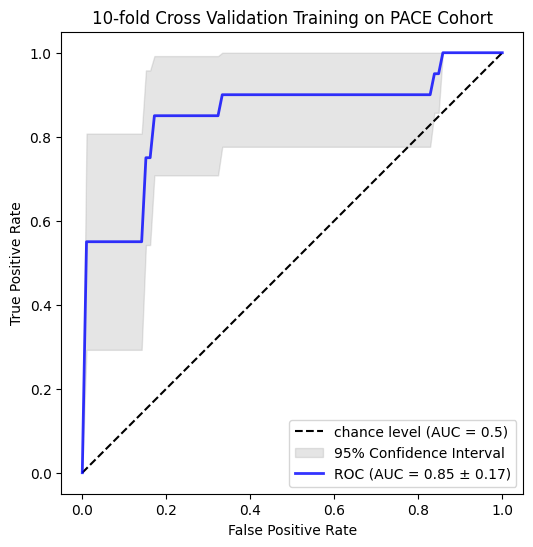

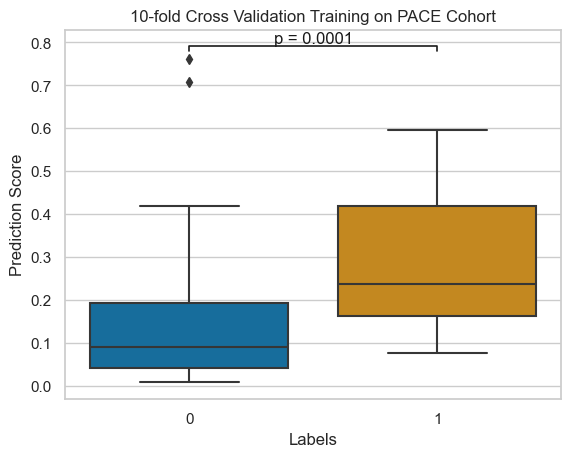

In [6]:
from sklearn.model_selection import StratifiedKFold
# Training Stats

cv = StratifiedKFold(n_splits=10)

plot_training_roc_curve_ci(
    model, X_train, y_train,
    title='10-fold Cross Validation Training on PACE Cohort',
    cv = cv,
    # save_path = '/Users/muller/Documents/RugglesLab/publications/pace_press/Pace Edits/training_roc.pdf'
    )

plot_training_probas(
    model, X_train, y_train,
    title='10-fold Cross Validation Training on PACE Cohort',
    cv = cv,
    # save_path = '/Users/muller/Documents/RugglesLab/publications/pace_press/Pace Edits/pace_boxplot.pdf'
)

              precision    recall  f1-score   support

           0       0.83      0.48      0.61        21
           1       0.52      0.86      0.65        14

    accuracy                           0.63        35
   macro avg       0.68      0.67      0.63        35
weighted avg       0.71      0.63      0.62        35

AUC: 0.782312925170068


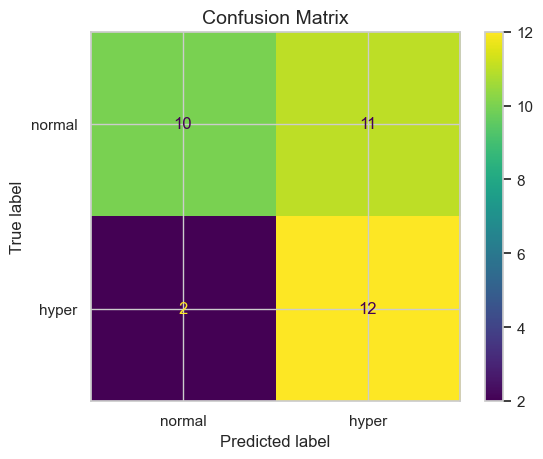

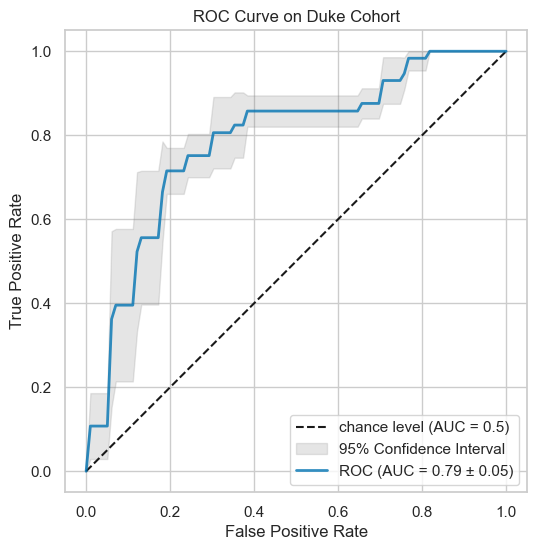

Logistic: PR AUC=0.672


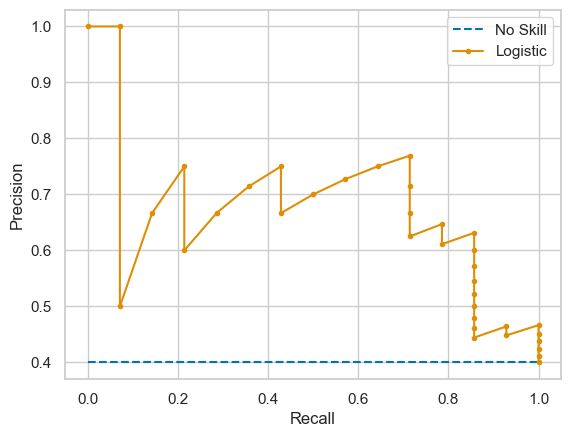

In [22]:

#### Metrics
print(classification_report(y_test, model.predict(X_test)))
print(f'AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1])}')
plot_confusion_matrix(y_test, model.predict(X_test), labels = ['normal', 'hyper'])
plot_roc_curve_ci(model, X_test, y_test, title='ROC Curve on Duke Cohort')

# plot the prc curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

# predict probabilities
lr_probs = model.predict_proba(X_test)[:,1]
# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
# calculate scores
lr_auc = auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: PR AUC=%.3f' % (lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [15]:
### Save Model

# dump(model, filename='models/jobs/press_01_model_voting_a_ton_of_trees.joblib')

### Model Disease Correlations

In [31]:
# ### Load in disease gene ratio data
# sle_ratios = pd.read_csv('data/model_validation/sle/sle_features_labels.csv', index_col=0)
# male_ratios = pd.read_csv('data/model_validation/male/male_features_labels.csv', index_col=0)
# mace_ratios = pd.read_csv('data/model_validation/mace/mace_features_labels.csv', index_col=0)
# covid_ratios = pd.read_csv('data/model_validation/covid/covid_features_labels.csv', index_col=0)
# pad_ratios = pd.read_csv('data/model_validation/pad/pad_features_labels.csv', index_col=0)
# harp_ratios = pd.read_csv('data/model_validation/harp/harp_features_labels.csv', index_col=0)


# ### Load in disease gene ratio data
# # sle_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/sle_gene_ratios_filtered_pace_60', index_col=0)
# # male_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/male_gene_ratios_filtered_pace_60', index_col=0)
# # mace_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/mace_gene_ratios_filtered_pace_60', index_col=0)
# # covid_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/covid_gene_ratios_filtered_pace_60', index_col=0)
# # pad_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/pad_gene_ratios_filtered_pace_60', index_col=0)
# # harp_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/harp_gene_ratios_filtered_pace_60', index_col=0)

# disease_ratios = {'sle':sle_ratios, 'male':male_ratios, 'mace':mace_ratios, 
#                   'covid':covid_ratios, 'pad':pad_ratios, 'harp':harp_ratios}

# male_ratios

In [32]:
# ### Prediction Results

# for key in disease_ratios.keys():
#     print(f'##################################### Current Disease: {key.upper()} #####################################')
    
#     features = disease_ratios[key].drop('cohort', axis=1)
#     labels = disease_ratios[key]['cohort']

#     print(classification_report(labels, model.predict(features)))

#     plot_roc_curve(labels, model.predict_proba(features)[:,1])


#         # Predict and graph things
#     preds = model.predict(features)
#     conf_matrx = confusion_matrix(labels, preds)
#     auc_score = roc_auc_score(labels, model.predict_proba(features)[:,1])


#     sns.heatmap(conf_matrx, xticklabels=["Normal", "Hyper"], yticklabels=["Healthy", key],
#                 cmap="Blues", annot=True, fmt='g').set_title(f"{key} Platelet Activity Correlations \nAUC: {auc_score:.2f}")
#     plt.show()


#     # Weird results here, so I figure making a histogram of the model is helpful
#     sns.set_theme(style="whitegrid", palette="colorblind")
#     df = pd.DataFrame({'preds' : model.predict_proba(features)[:,1]})
#     df['labels'] = labels.values
#     df['labels'] = df['labels'].map({0:"Normal", 1:key})
#     sns.boxplot(
#         df, x='labels', y='preds', 
#         order=["Normal", key], boxprops={'alpha': 0.75}
#         ).set(ylabel="Prediction Value", xlabel=None)
#     sns.stripplot(
#         df, x='labels', y='preds',
#         color = 'black', alpha = 0.75,
#         order=["Normal", key]
#         ).set(ylabel="Prediction Value", xlabel=None)

#     # Significance Testing (kruskal-wallis for nonparametric analysis)    
#     kruskal_wallis = kruskal(df.loc[df['labels'] == "Normal"]['preds'], df.loc[df['labels'] == key]['preds'])
#     if kruskal_wallis[1] < 0.05:
#         # statistical annotation
#         x1, x2 = 0, 1
#         y, h = df['preds'].max()+0.01, 0.01
#         plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.2, c='k')
#         plt.text((x1+x2)*.5, y+h, f"p = {kruskal_wallis[1]:.4f}",
#                  ha='center', va='bottom', color='k')

#     plt.show()